Difference from neid_fiesta_daily.ipynb:
Weightd average in the uncertainties 

In [1]:
import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
from datetime import datetime

from FIESTA_functions import *
from HARPS_N_functions import *
from NEID_solar_functions import *
from functions import *
#----------------------------------
# Read data
#----------------------------------


In [2]:
if 1:
    v_grid  = np.loadtxt('../lib/data_v4/v_grid.txt')
    CCF     = np.loadtxt('../lib/data_v4/CCF.txt')
    σCCF   = np.loadtxt('../lib/data_v4/σCCF.txt')
    bjd     = np.loadtxt('../lib/data_v4/bjd.txt')
    rv      = np.loadtxt('../lib/data_v4/rv.txt')
    σrv     = np.loadtxt('../lib/data_v4/σrv.txt')
    idx_rej = np.array(np.loadtxt('../lib/data_v4/idx_rej'), dtype=bool)
    
    # idx_v = (v_grid>90.25) & (v_grid<107.5)
    # v_grid = v_grid[idx_v]
    
    CCF = CCF[:,~idx_rej]
    σCCF = σCCF[:,~idx_rej]
    # CCF = CCF[idx_v,:]
    # σCCF = σCCF[idx_v,:]    
    bjd = bjd[~idx_rej]
    rv = rv[~idx_rej]
    σrv = σrv[~idx_rej]

In [3]:
weighted_avg_and_std(rv, 1/σrv**2), # weighted_avg_and_std(rv_daily, 1/σrv_daily**2)

((-640.7388741816881, 1.4227938184859392),)

In [4]:
if 0:
    v_grid  = np.loadtxt('../lib/data_526_625/v_grid.txt')
    CCF     = np.loadtxt('../lib/data_526_625/CCF.txt')
    σCCF   = np.loadtxt('../lib/data_526_625/σ_CCF.txt')
    bjd     = np.loadtxt('../lib/data_526_625/bjd.txt')
    rv      = np.loadtxt('../lib/data_526_625/rv.txt')
    σrv     = np.loadtxt('../lib/data_526_625/σrv.txt')

    idx_t = (bjd<2459392) & (bjd>2459361)

    CCF = CCF[idx_v,idx_t]
    σCCF = σCCF[idx_v,idx_t]
    bjd = bjd[idx_t]
    rv = rv[idx_t]
    σrv = σrv[idx_t]


In [5]:
σCCF.shape, CCF.shape, v_grid.shape

((95, 31145), (95, 31145), (95,))

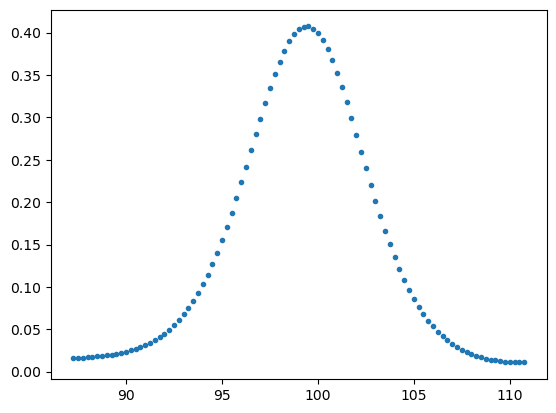

In [6]:
plt.plot(v_grid, CCF[:,0], '.')
plt.show()

In [9]:
# plt.plot(v_grid, (CCF.T-np.mean(CCF,axis=1)).T)
# plt.show()

Daily averages

<ErrorbarContainer object of 3 artists>

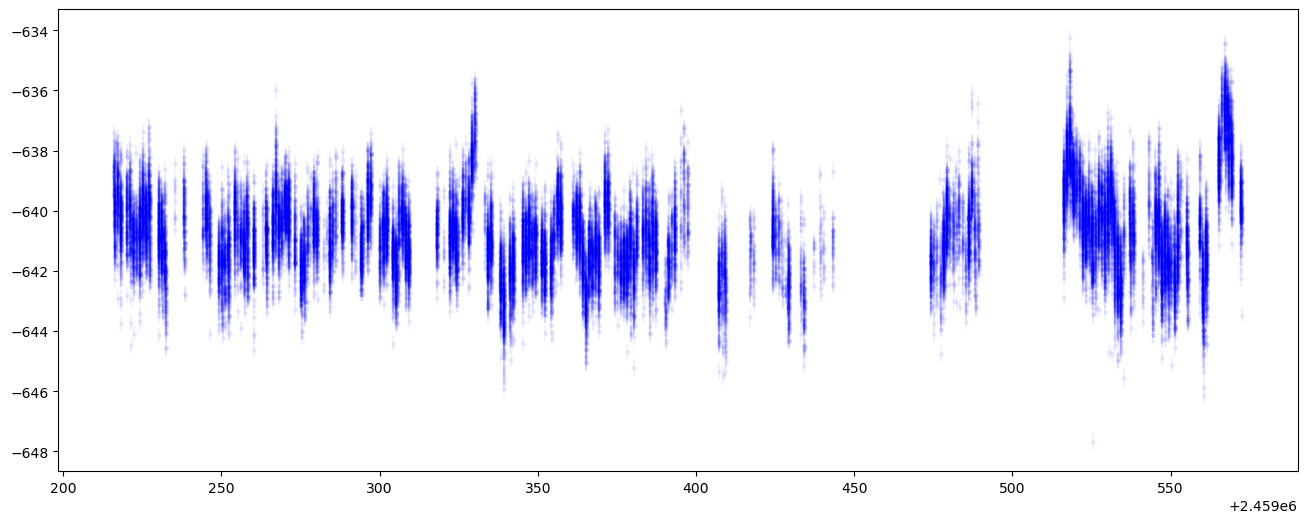

In [7]:
fig = plt.figure(figsize=(16, 6))
plt.errorbar(bjd, rv, σrv, marker='.', ms=5, color='blue', ls='none', alpha=0.05)

In [9]:
t_min = int(min(bjd))
t_max = int(max(bjd))
N = t_max -t_min + 1

bjd_daily 			= np.zeros(N)
CCF_daily 			= np.zeros((len(v_grid), N))
σCCF_daily			= np.zeros((len(v_grid), N))
rv_daily			= np.zeros(N)
# rv_raw_daily		= np.zeros(N)
σrv_daily			= np.zeros(N)

for n in range(N):
    idx = (bjd>(t_min+n)) & (bjd<(t_min+n+0.5))
    if len(bjd[idx])!=0:
        bjd_daily[n] = weighted_avg_1D(bjd[idx], 1/σrv[idx]**2)
        rv_daily[n] =  weighted_avg_1D(rv[idx], 1/σrv[idx]**2)
        σrv_daily[n] = 1/np.sqrt(np.sum(1/σrv[idx]**2))
        CCF_daily[:,n] = 1-weighted_avg_2D(1-CCF[:,idx], 1/σrv[idx]**2)
        σCCF_daily[:,n] = 1/np.sqrt(np.sum(1/σCCF[:,idx]**2, axis=1))

In [10]:
idx_0 		= (rv_daily==0)
rv_daily 	= rv_daily[~idx_0]
# rv_raw_daily= rv_raw_daily[~idx_0]
σrv_daily 	= σrv_daily[~idx_0]
bjd_daily 	= bjd_daily[~idx_0]
CCF_daily 	= CCF_daily[:,~idx_0]
σCCF_daily 	= σCCF_daily[:,~idx_0]

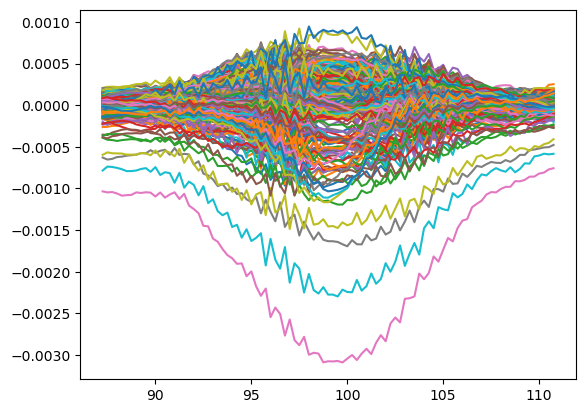

In [11]:
plt.plot(v_grid, (CCF_daily.T-np.mean(CCF_daily,axis=1)).T)
plt.show()

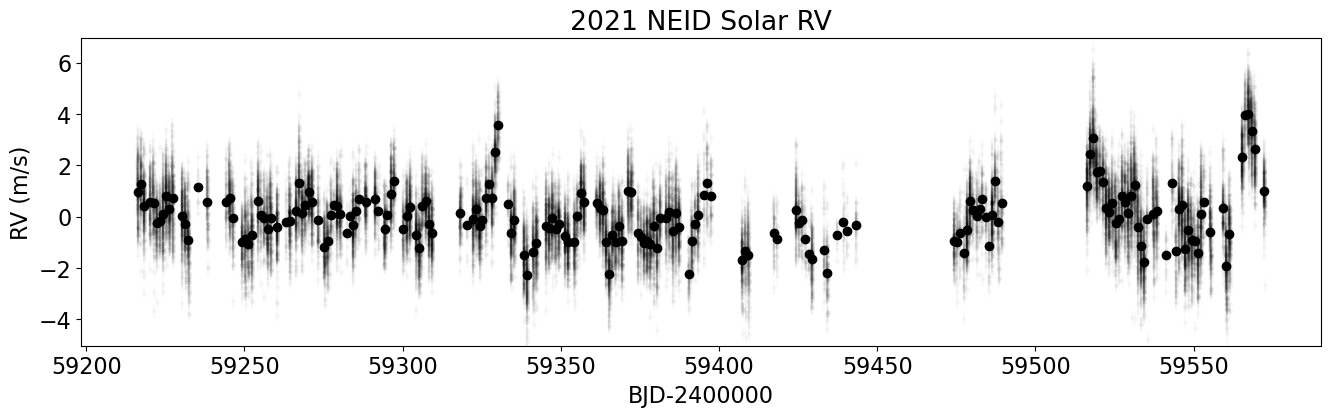

In [13]:
plt.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(16, 4))
plt.errorbar(bjd-2400000, rv-np.mean(rv_daily), σrv, marker='.', ms=5, color='k', ls='none', alpha=0.02)
plt.errorbar(bjd_daily-2400000, rv_daily-np.mean(rv_daily), σrv_daily, marker='.', ms=12, color='black', ls='none')
plt.ylim([np.median(rv-np.mean(rv_daily))-5, np.median(rv-np.mean(rv_daily))+7])
plt.title('2021 NEID Solar RV')
plt.xlabel('BJD-2400000')
plt.ylabel('RV (m/s)')
plt.savefig('../Figures/NEID_solar_RV_2021.png')
plt.show()

## FIESTA on daily CCF analysis

In [16]:
k_max = 55
df, RV_FT_k, eRV_FT_k, A_k, eA_k, RV_gauss = FIESTA(v_grid, CCF_daily, σCCF_daily, k_max=k_max)

RV_FT_k  *= 1000
eRV_FT_k *= 1000
RV_gauss *= 1000
ΔRV_k     = RV_FT_k - RV_gauss


## Plots 

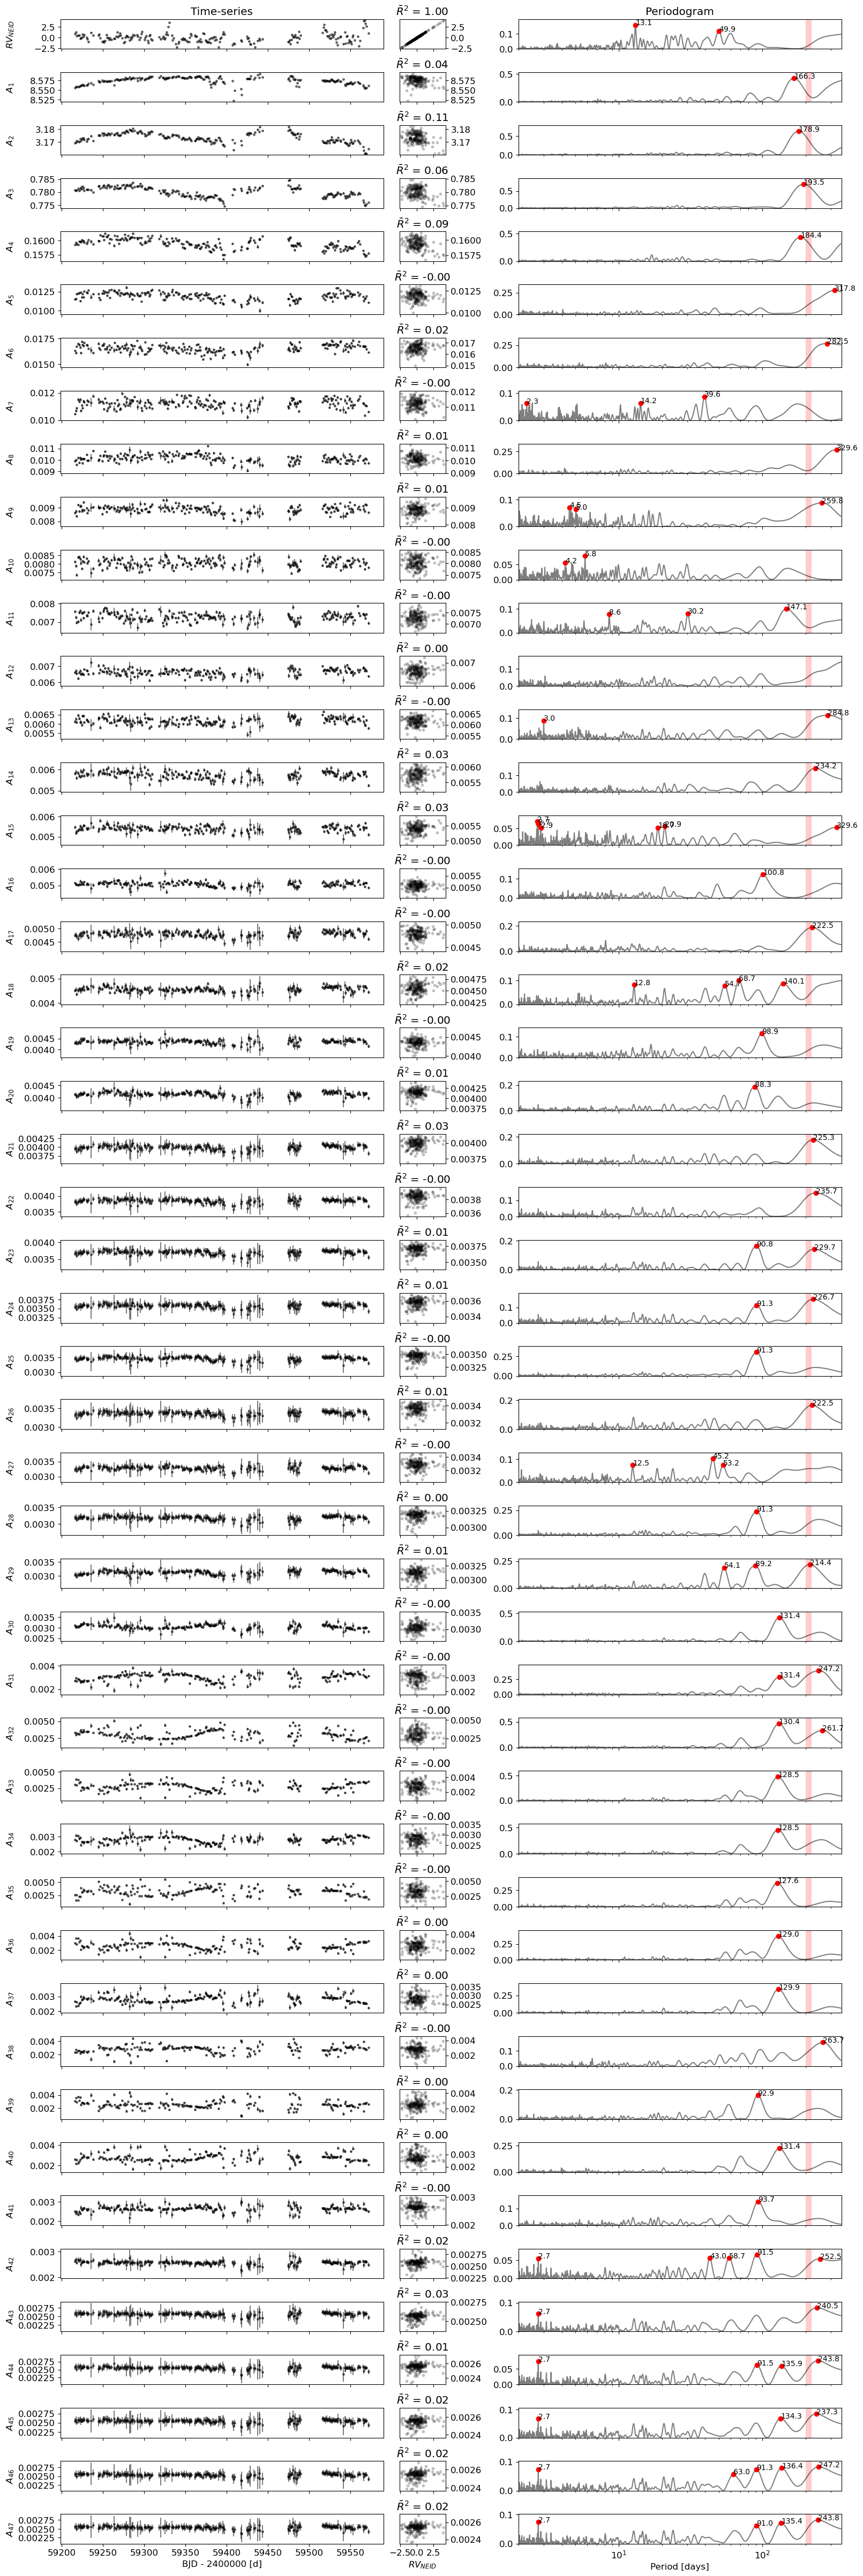

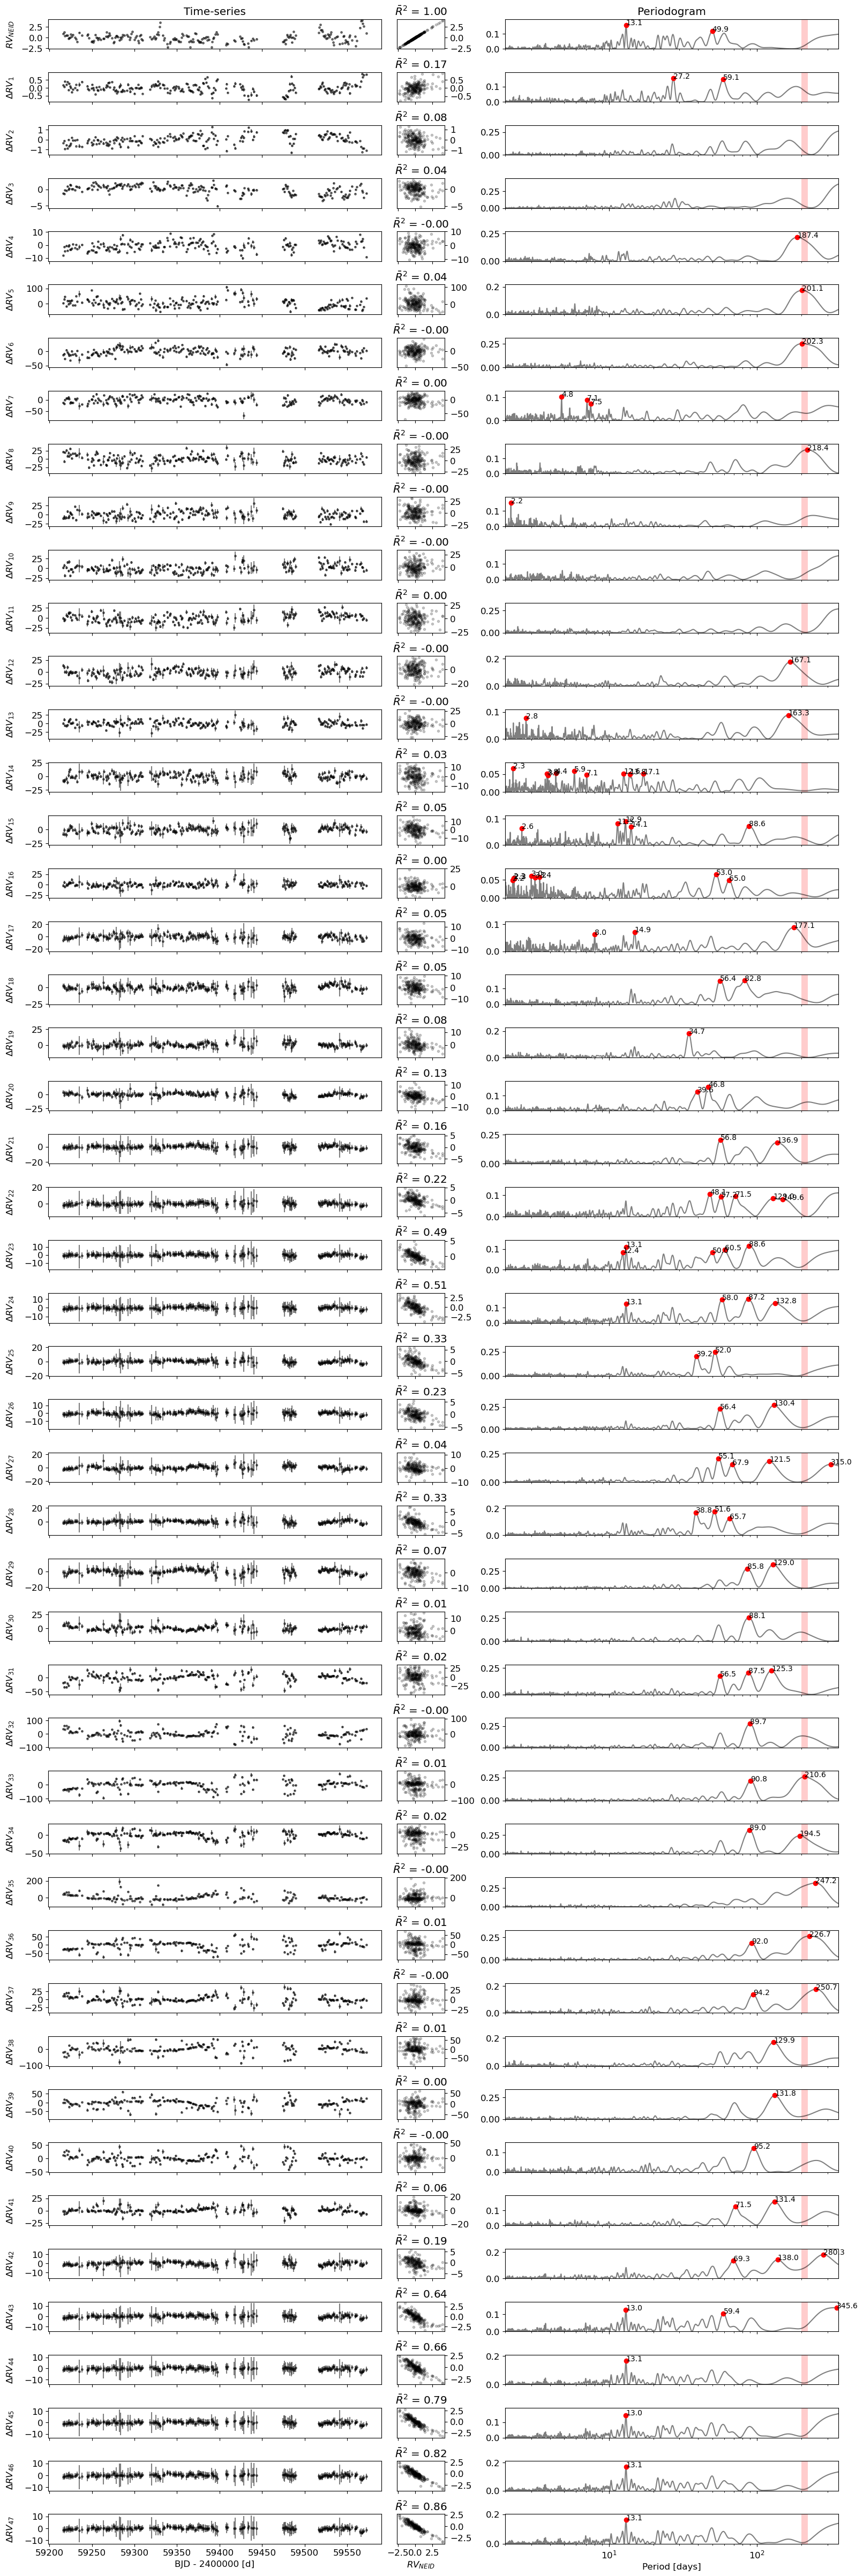

In [17]:
k_max = A_k.shape[0]

plot_all(k_mode=k_max, t=bjd_daily-2400000, rv=rv_daily, erv=σrv_daily, 
    ind=A_k, eind=eA_k, 
    ts_xlabel='BJD - 2400000 [d]', 
    rv_xlabel='$RV_{NEID}$', 
    pe_xlabel='Period [days]',
    ind_yalbel=r'$A$',
    file_name='')
plt.show()

plot_all(k_mode=k_max, t=bjd_daily-2400000, rv=rv_daily, erv=σrv_daily, 
    ind=ΔRV_k, eind=eRV_FT_k, 
    ts_xlabel='BJD - 2400000 [d]', 
    rv_xlabel='$RV_{NEID}$', 
    pe_xlabel='Period [days]',
    ind_yalbel=r'$\Delta RV$',
    file_name='')
plt.show()

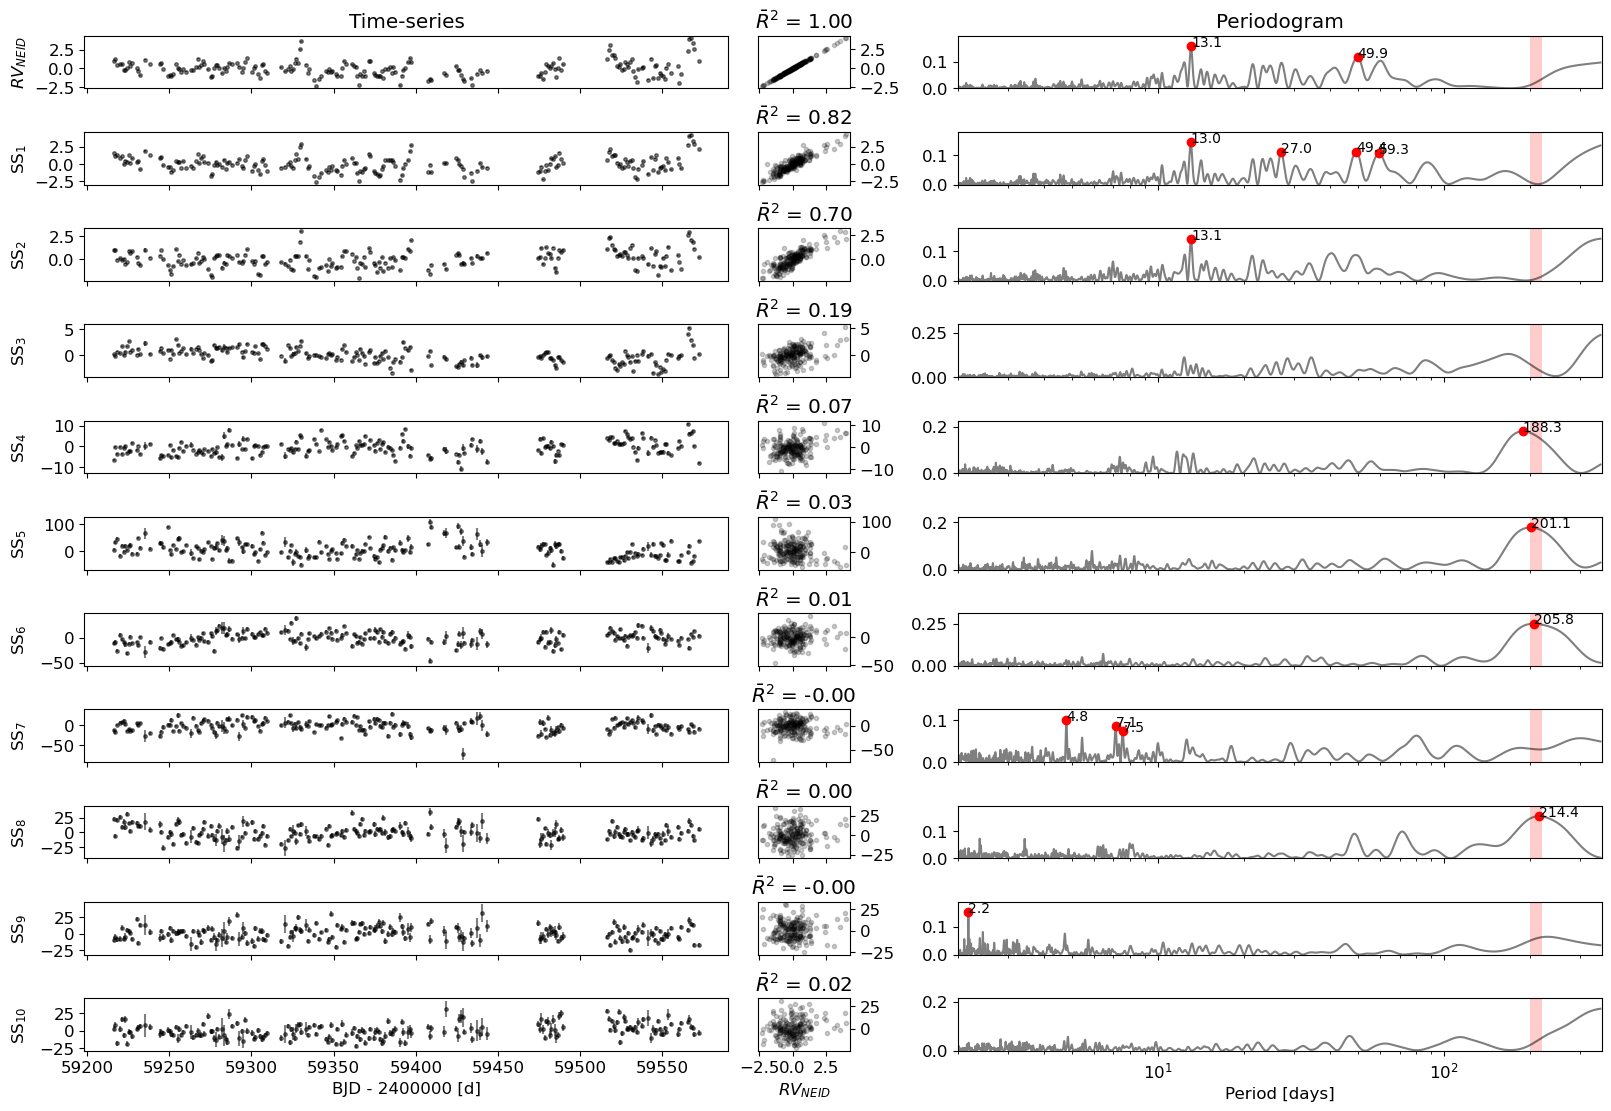

In [18]:
plot_all(k_mode=10, t=bjd_daily-2400000, rv=rv_daily, erv=σrv_daily, 
    ind=RV_FT_k, eind=eRV_FT_k, 
    ts_xlabel='BJD - 2400000 [d]', 
    rv_xlabel='$RV_{NEID}$', 
    pe_xlabel='Period [days]',
    ind_yalbel='SS',
    file_name='')
plt.show()

# PCA

In [19]:
k_max = 47
PC, weighted_pca_score, err_weighted_pca_score, n_pca = weighted_pca(X=ΔRV_k[:k_max,:].T, X_err=eRV_FT_k[:k_max,:].T, nor=False)

Cumulative variance explained vs PCA components
1 	 44.206
2 	 61.858
3 	 77.911
4 	 82.338
5 	 86.273
6 	 89.251
7 	 91.666
8 	 93.685
9 	 95.150
10 	 96.414
11 	 97.417
12 	 98.181
13 	 98.888
14 	 99.397
15 	 99.880
16 	 100.233
17 	 100.560
18 	 100.801
19 	 100.997
20 	 101.164
21 	 101.274
22 	 101.361
23 	 101.413
24 	 101.448
25 	 101.476
26 	 101.492
27 	 101.502
28 	 101.509
29 	 101.515
30 	 101.519
31 	 101.523
32 	 101.526
33 	 101.529
34 	 101.531
35 	 101.532
36 	 101.534
37 	 101.534
38 	 101.535
39 	 101.535
40 	 101.535
41 	 101.535
42 	 101.535
43 	 101.535
44 	 101.533
45 	 101.394
46 	 101.129
47 	 100.000
7 pca scores account for 91.67% variance explained
Standard deviations of each component and the midean uncertainty are
 [61.6 35.  29.5 15.  14.  11.6 10.9] 
 [3.1 3.4 4.5 3.5 3.3 3.5 3.5]


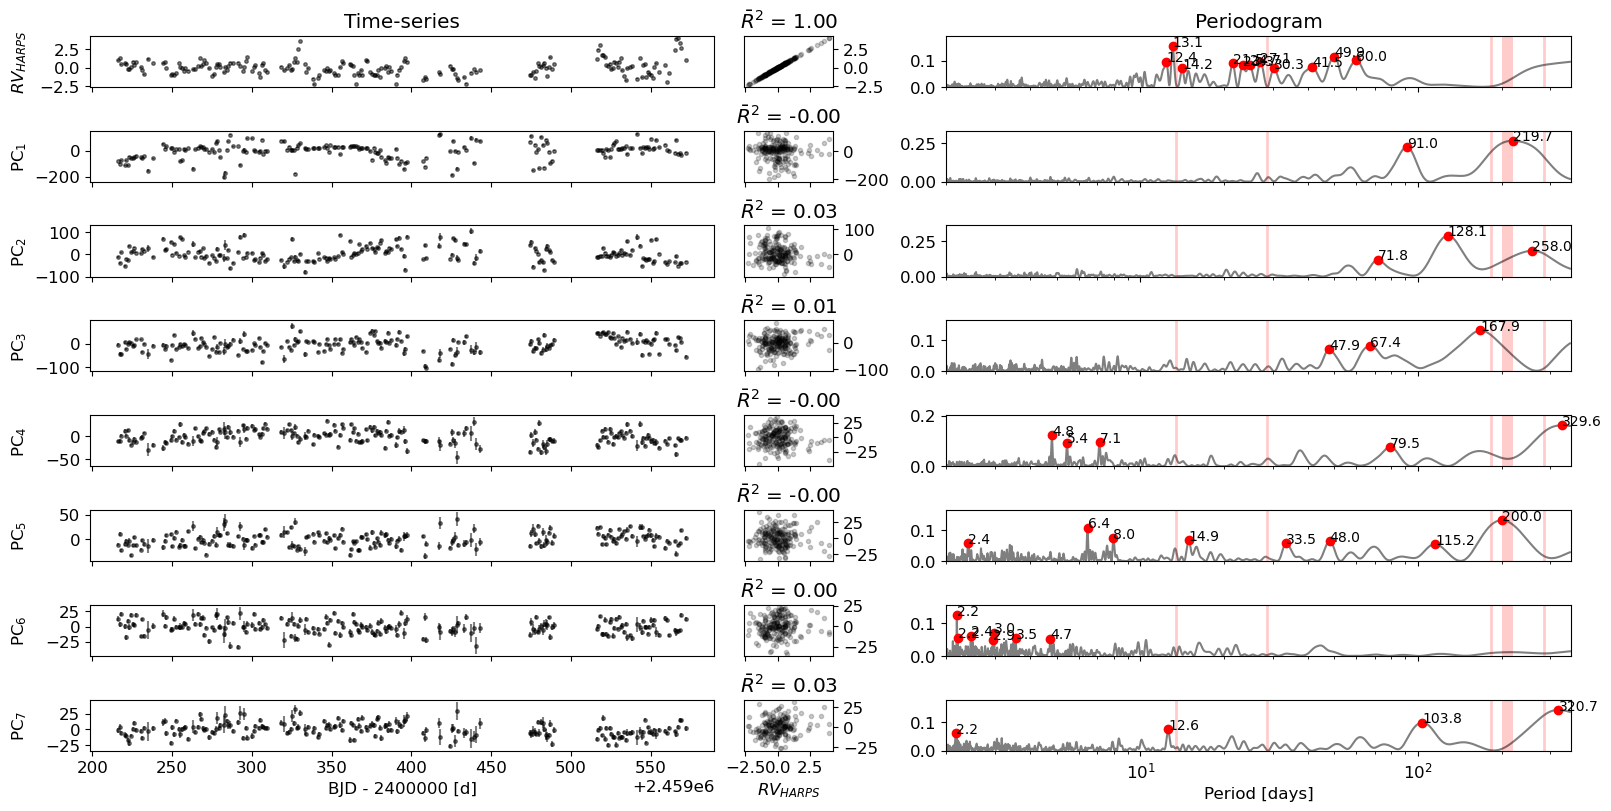

In [20]:
plot_all(k_mode=7, t=bjd_daily, rv=rv_daily, erv=σrv_daily, 
    vlines = [13.4, 28.5, 365/2, 285, 400],
    ind=weighted_pca_score.T, eind=err_weighted_pca_score.T, 
    ts_xlabel='BJD - 2400000 [d]', 
    rv_xlabel='$RV_{HARPS}$', 
    pe_xlabel='Period [days]',
    ind_yalbel='PC',
    height_ratio=0.4,
    file_name='')

# MLP

In [21]:
import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras import utils
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses
from sklearn.utils import shuffle

# print(tf.VERSION)
print(tf.keras.__version__)

2023-03-26 17:29:29.295478: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 17:29:29.458308: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-26 17:29:31.087121: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /storage/icds/RISE/sw8/julia-1.8.1/julia-1.8.1/lib:/storage/icds/RISE/sw8/anaconda/a

2.10.0


In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# def model_MLP(X, Y, lr_model, batch_size=64, epochs=200, learning_rate=2e-4):
def model_MLP(X, Y, lr_model, epochs=200, learning_rate=2e-4):

    scaler = StandardScaler()
    scaler.fit_transform(X)
    x_train, x_test, y_train, y_test, t_train, t_test, σrv_train, σrv_test = train_test_split(X, Y, bjd_daily, σrv_daily, test_size=0.3, random_state=40)
    x_train.shape, x_test.shape

    batch_size= x_train.shape[0]
    input_dim = x_train.shape[1]

    ###################
    # hyperparameters #
    ###################
    # 1st to play with learning rate
    # 2nd batch size 
    # then epochs and activation functions 
    # batch_size = batch_size
    # epochs=epochs
    adam = Adam(learning_rate=learning_rate)
    
    
    def custom_mse(y_test, y_pred):
        squared_difference = tf.dtypes.cast(tf.square((y_test - y_pred)/σrv_test), tf.float64) 
        return tf.dtypes.cast(tf.reduce_mean(squared_difference/tf.square(1/σrv_test), axis=-1), tf.float64)  # Note the `axis=-1`
    
    # compile the model
    lr_model.compile(loss=custom_mse,
                  optimizer=adam,
                  metrics=[custom_mse])

    # from keras.callbacks import EarlyStopping
    # earlystop = EarlyStopping(monitor = 'val_mse',
    #                           min_delta = 0,
    #                           patience = 3,
    #                           verbose = 0,
    #                           restore_best_weights = True)

    # callback = tf.keras.callbacks.EarlyStopping(monitor='custom_mse', patience=20)

    ### Fit the model
    lr_model_history = lr_model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        # callbacks = [callback],
                        validation_data=(x_test, y_test))

    fig, ax = plt.subplots(1, 1)
    ax.plot(np.sqrt(lr_model_history.history['loss']), 'b', label='train')    
    ax.plot(np.sqrt(lr_model_history.history['val_loss']), 'r' ,label='test')
    
    ax.set_xlabel(r'Epoch')
    ax.set_ylabel(r'wmse')
    ax.set_yscale('log')
    ax.legend()
    ax.tick_params(labelsize=20)
    # ax.set_xlim([20, epochs])
    # ax.set_ylim([0, 2])
    plt.show()
    
    
    y_pred = lr_model.predict(x_test)
    plt.plot(t_test, y_test, 'r.', label='test')
    plt.plot(t_test, y_pred, 'k.', label='pred')
    plt.ylabel('RV [m/s]')
    plt.legend()
    plt.show()

    plt.plot(y_test, y_pred, 'b.')
    plt.xlabel('test [m/s]')
    plt.ylabel('pred [m/s]')
    plt.show()    
    
    print(weighted_avg_and_std(y_pred[:,0]-y_test, 1/σrv_test**2))
    
    return y_test, y_pred[:,0]
    

(202, 47) (202,)


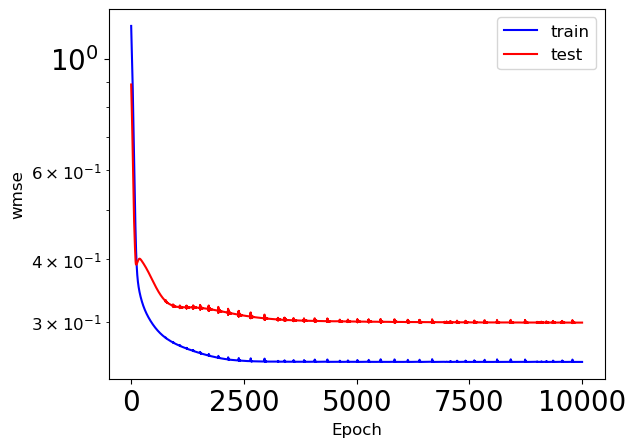

2/2 [==============================] - 0s 2ms/step


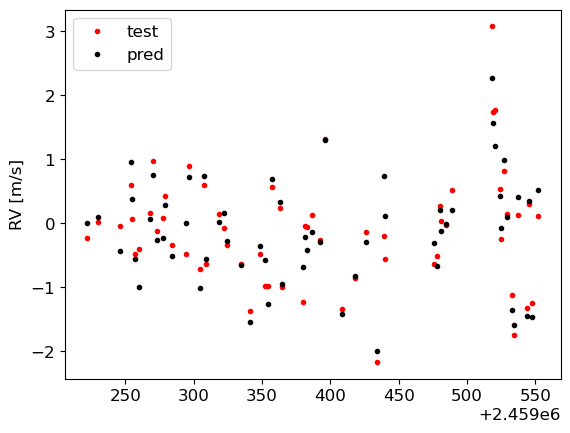

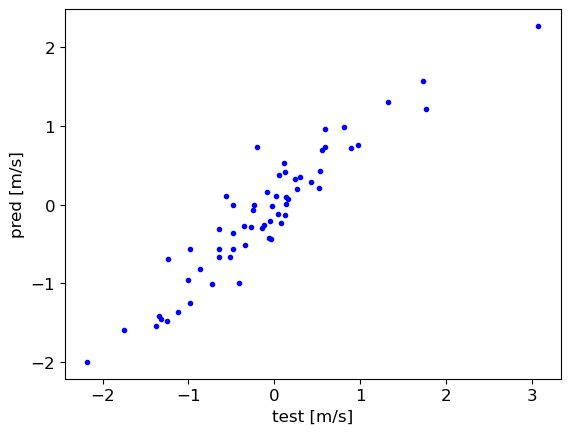

(-0.028124753495525318, 0.2764273121149707)


In [23]:
# X = ΔRV_k.T[:,0:10]
X = ΔRV_k.T
Y = rv_daily - np.mean(rv_daily)
print(X.shape, Y.shape)
###################
# build the model #
###################
input_dim = X.shape[1]
lr_model = Sequential()
# lr_model.add(Dense(32, activation=tf.nn.relu, kernel_initializer='uniform', 
#                 input_dim = input_dim)) 
# lr_model.add(Dense(16, kernel_initializer='uniform', activation=tf.nn.relu))
lr_model.add(Dense(16, activation=tf.keras.activations.linear, kernel_initializer='uniform', 
                input_dim = input_dim)) # add bias term!
# lr_model.add(Dense(20, kernel_initializer='uniform', activation=tf.nn.relu))
# lr_model.add(Dense(20, kernel_initializer='uniform', activation=tf.nn.relu))
# lr_model.add(Dense(20, kernel_initializer='uniform', activation=tf.nn.tanh))
lr_model.add(Dense(1, kernel_initializer='uniform', activation=tf.keras.activations.linear))

y_test, y_pred = model_MLP(X, Y, lr_model, epochs=10000, learning_rate=5e-4)

(202, 23) (202,)


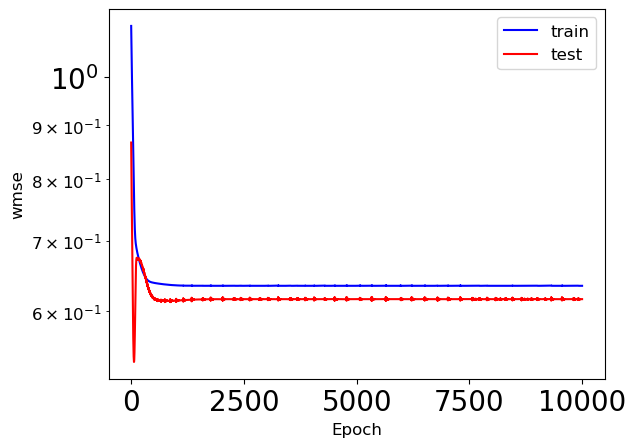

2/2 [==============================] - 0s 3ms/step


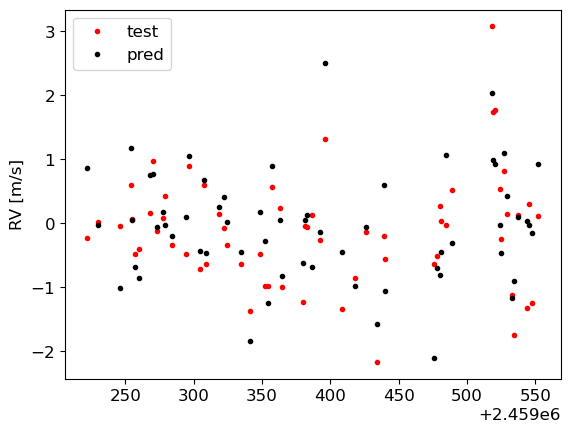

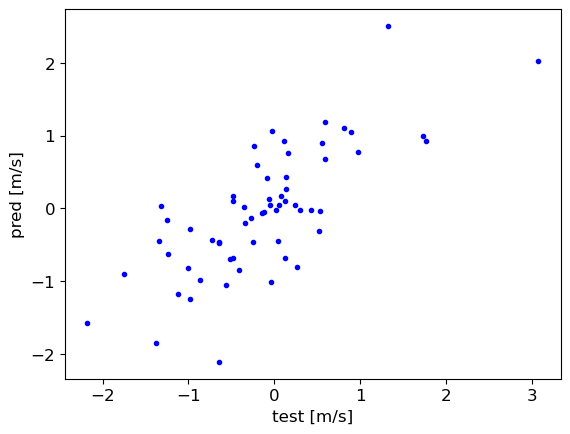

(0.07654492174558217, 0.5388987446233646)


In [24]:
X = ΔRV_k.T[:,0:23]
# X = ΔRV_k.T
Y = rv_daily - np.mean(rv_daily)
print(X.shape, Y.shape)
###################
# build the model #
###################
input_dim = X.shape[1]
lr_model = Sequential()
# lr_model.add(Dense(32, activation=tf.nn.relu, kernel_initializer='uniform', 
#                 input_dim = input_dim)) 
# lr_model.add(Dense(16, kernel_initializer='uniform', activation=tf.nn.relu))
lr_model.add(Dense(16, activation=tf.keras.activations.linear, kernel_initializer='uniform', 
                input_dim = input_dim)) # add bias term!
# lr_model.add(Dense(20, kernel_initializer='uniform', activation=tf.nn.relu))
# lr_model.add(Dense(20, kernel_initializer='uniform', activation=tf.nn.relu))
# lr_model.add(Dense(20, kernel_initializer='uniform', activation=tf.nn.tanh))
lr_model.add(Dense(1, kernel_initializer='uniform', activation=tf.keras.activations.linear))

y_test, y_pred = model_MLP(X, Y, lr_model, epochs=10000, learning_rate=1e-3)

(202, 47) (202,)


2023-03-26 17:42:23.450773: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


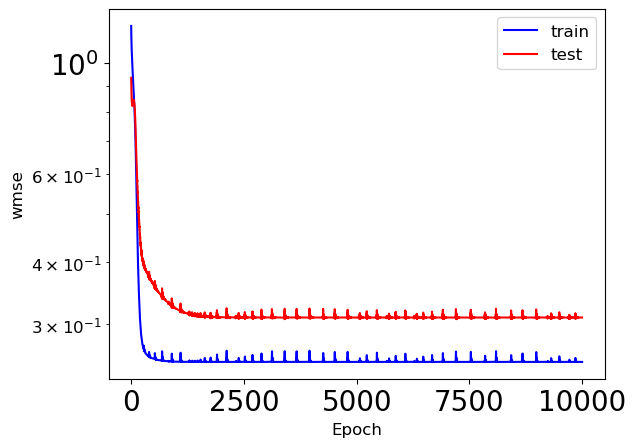

2/2 [==============================] - 0s 2ms/step


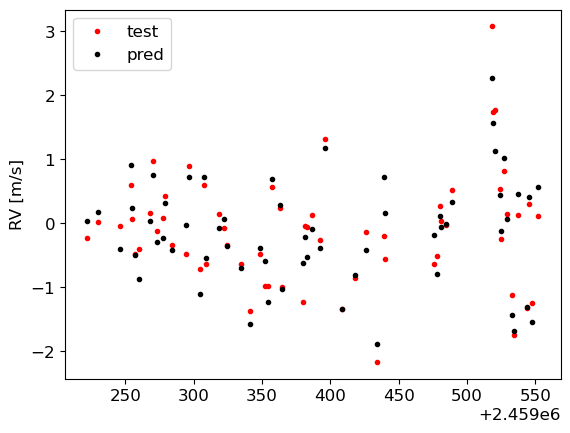

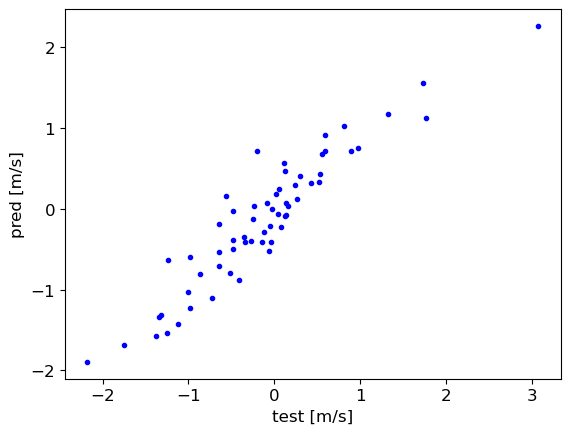

(-0.03973350604775952, 0.28198274062460404)


In [25]:
# X = ΔRV_k.T[:,0:10]
X = RV_FT_k.T
Y = rv_daily - np.mean(rv_daily)
print(X.shape, Y.shape)
###################
# build the model #
###################
input_dim = X.shape[1]
lr_model = Sequential()
# lr_model.add(Dense(32, activation=tf.nn.relu, kernel_initializer='uniform', 
#                 input_dim = input_dim)) 
# lr_model.add(Dense(16, kernel_initializer='uniform', activation=tf.nn.relu))
lr_model.add(Dense(16, activation=tf.keras.activations.linear, kernel_initializer='uniform', 
                input_dim = input_dim)) # add bias term!
# lr_model.add(Dense(20, kernel_initializer='uniform', activation=tf.nn.relu))
# lr_model.add(Dense(20, kernel_initializer='uniform', activation=tf.nn.relu))
# lr_model.add(Dense(20, kernel_initializer='uniform', activation=tf.nn.tanh))
lr_model.add(Dense(1, kernel_initializer='uniform', activation=tf.keras.activations.linear))

y_test, y_pred = model_MLP(X, Y, lr_model, epochs=10000, learning_rate=1e-3)

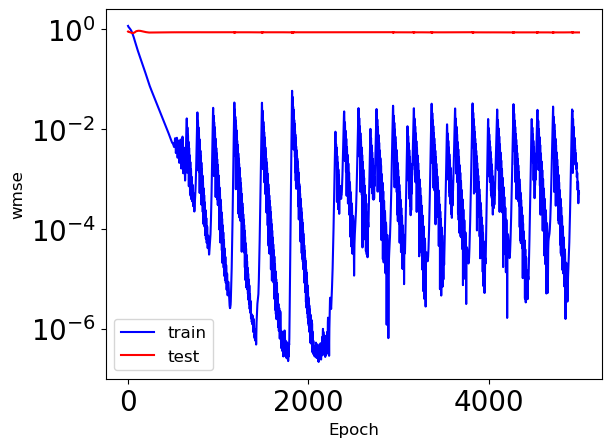

2/2 [==============================] - 0s 3ms/step


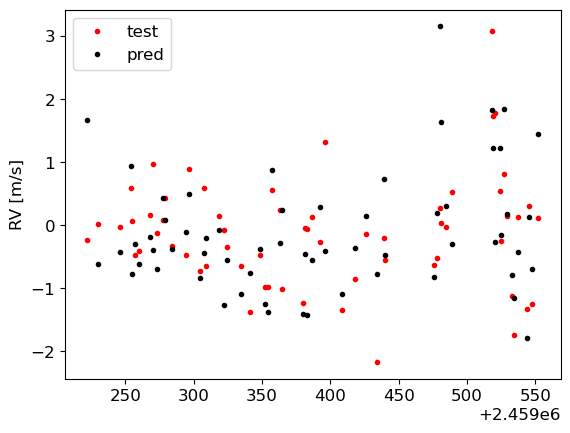

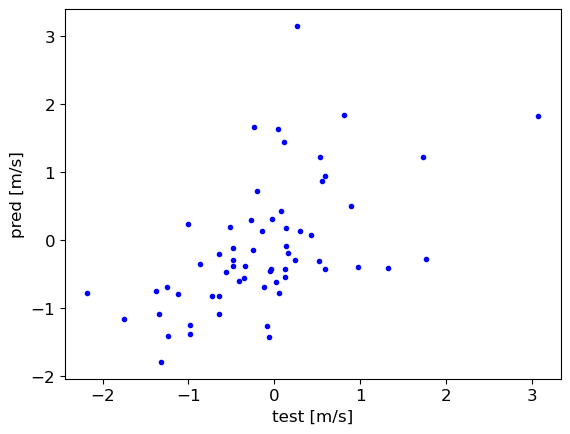

(-0.04652975141473265, 0.7710656873917842)


In [26]:
lr_model = Sequential()
lr_model.add(Dense(16, kernel_initializer='uniform', activation=tf.nn.relu))
# lr_model.add(Dense(16, kernel_initializer='uniform', activation=tf.nn.relu))
# lr_model.add(Dense(16, kernel_initializer='uniform', activation=tf.nn.relu))
lr_model.add(Dense(1, kernel_initializer='uniform', activation=tf.keras.activations.linear))

y_test, y_pred = model_MLP(X, Y, lr_model, epochs=5000, learning_rate=1e-3)

(202, 47) (202,)


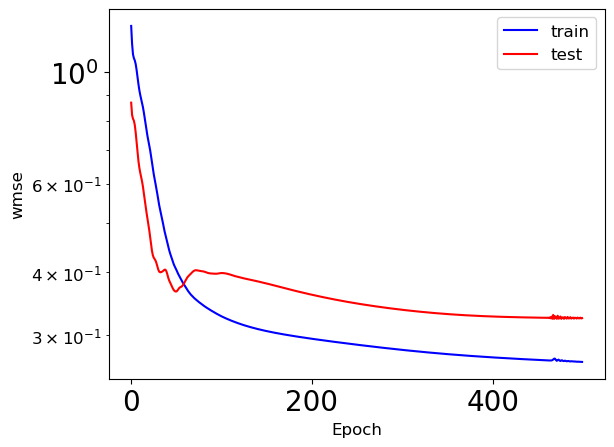

2/2 [==============================] - 0s 3ms/step


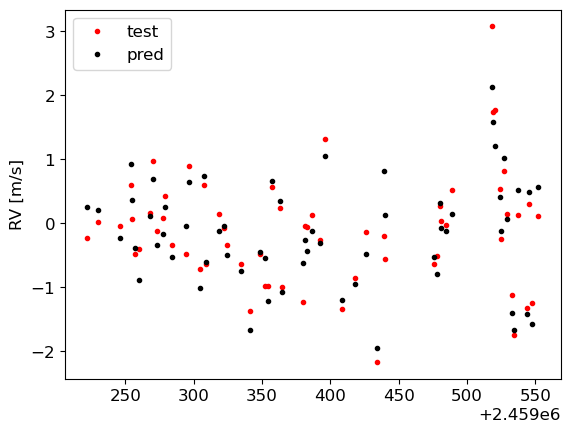

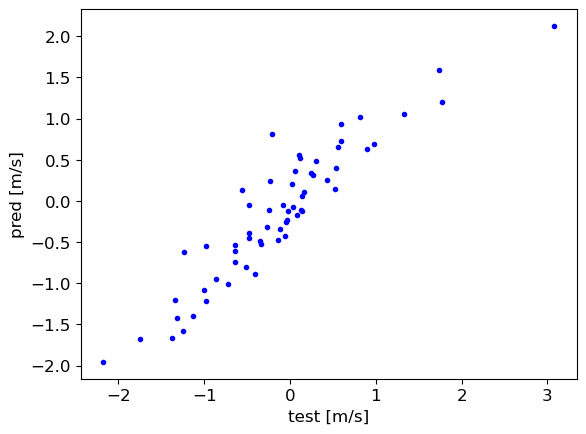

(-0.04782845051326708, 0.30088972917557344)


In [27]:
# X = ΔRV_k.T[:,0:10]
X = ΔRV_k.T
Y = rv_daily - np.mean(rv_daily)
print(X.shape, Y.shape)
###################
# build the model #
###################
input_dim = X.shape[1]
lr_model = Sequential()
# lr_model.add(Dense(32, activation=tf.nn.relu, kernel_initializer='uniform', 
#                 input_dim = input_dim)) 
# lr_model.add(Dense(16, kernel_initializer='uniform', activation=tf.nn.relu))
lr_model.add(Dense(40, activation=tf.keras.activations.linear, kernel_initializer='uniform', 
                input_dim = input_dim)) # add bias term!
# lr_model.add(Dense(20, kernel_initializer='uniform', activation=tf.nn.relu))
# lr_model.add(Dense(20, kernel_initializer='uniform', activation=tf.nn.tanh))
lr_model.add(Dense(1, kernel_initializer='uniform', activation=tf.keras.activations.linear))

y_test, y_pred = model_MLP(X, Y, lr_model, epochs=500, learning_rate=1e-3)

(202, 47) (202,)


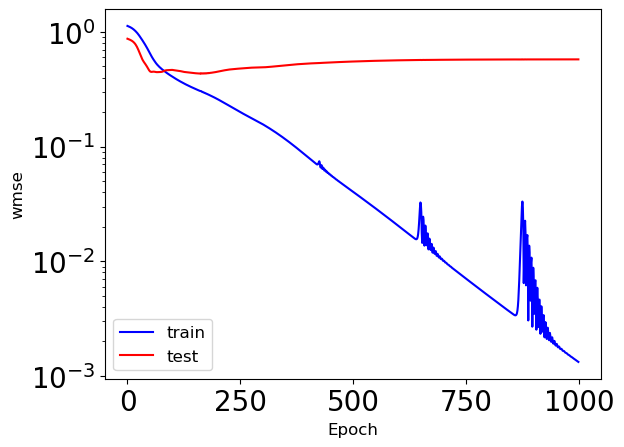

2/2 [==============================] - 0s 4ms/step


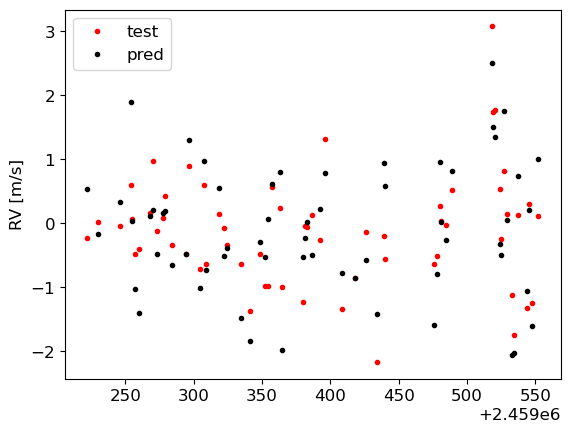

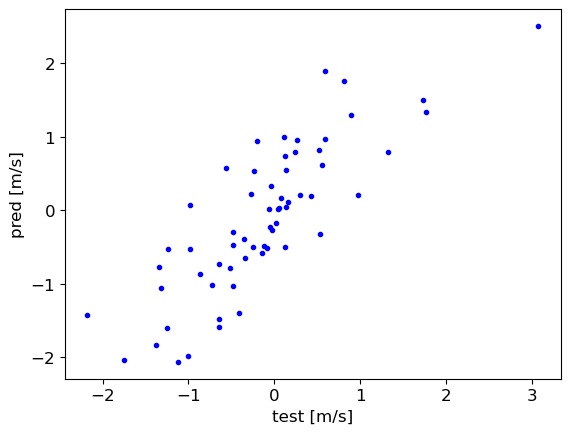

(-0.0538080062679907, 0.5625935645689444)


In [28]:
# X = ΔRV_k.T[:,0:10]
X = ΔRV_k.T
Y = rv_daily - np.mean(rv_daily)
print(X.shape, Y.shape)
###################
# build the model #
###################
input_dim = X.shape[1]
lr_model = Sequential()
# lr_model.add(Dense(32, activation=tf.nn.relu, kernel_initializer='uniform', 
#                 input_dim = input_dim)) 
# lr_model.add(Dense(16, kernel_initializer='uniform', activation=tf.nn.relu))
lr_model.add(Dense(16, activation=tf.keras.activations.linear, kernel_initializer='uniform', 
                input_dim = input_dim)) # add bias tern!
# lr_model.add(Dropout(0.1))
# lr_model.add(Dense(40, kernel_initializer='uniform', activation=tf.nn.relu))
# lr_model.add(Dense(20, kernel_initializer='uniform', activation=tf.nn.relu))
# lr_model.add(Dense(4, kernel_initializer='uniform', activation=tf.nn.relu))
lr_model.add(Dense(20, kernel_initializer='uniform', activation=tf.nn.tanh))
lr_model.add(Dense(1, kernel_initializer='uniform', activation=tf.keras.activations.linear))

y_test, y_pred = model_MLP(X, Y, lr_model, epochs=1000, learning_rate=1e-3)



(202, 30) (202,)


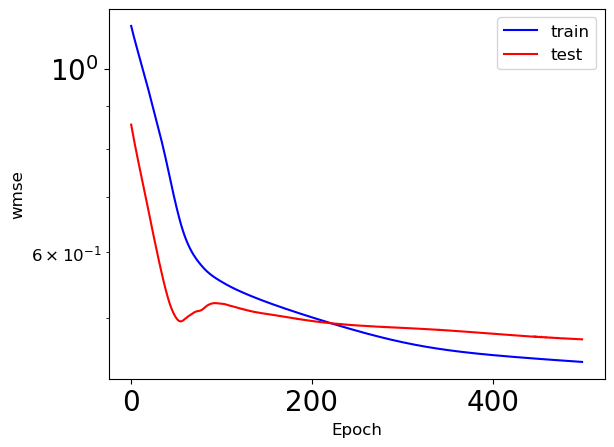

2/2 [==============================] - 0s 3ms/step


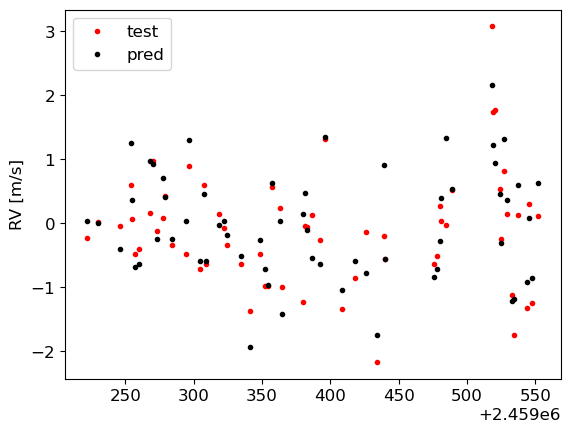

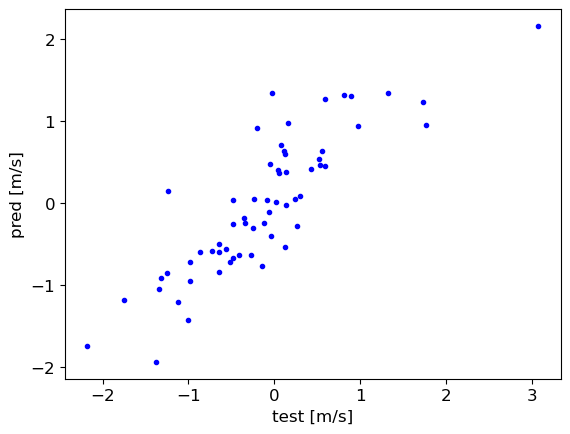

(0.060894509966865594, 0.41489878106515093)


In [29]:
X = ΔRV_k.T[:,0:30]
# X = ΔRV_k.T
Y = rv_daily - np.mean(rv_daily)
print(X.shape, Y.shape)
###################
# build the model #
###################
input_dim = X.shape[1]
lr_model = Sequential()
# lr_model.add(Dense(32, activation=tf.nn.relu, kernel_initializer='uniform', 
#                 input_dim = input_dim)) 
# lr_model.add(Dense(16, kernel_initializer='uniform', activation=tf.nn.relu))
lr_model.add(Dense(16, activation=tf.keras.activations.linear, kernel_initializer='uniform', 
                input_dim = input_dim)) # add bias term!
# lr_model.add(Dense(20, kernel_initializer='uniform', activation=tf.nn.relu))
# lr_model.add(Dense(20, kernel_initializer='uniform', activation=tf.nn.tanh))
lr_model.add(Dense(1, kernel_initializer='uniform', activation=tf.keras.activations.linear))

y_test, y_pred = model_MLP(X, Y, lr_model,  epochs=500, learning_rate=1e-3)

(202, 95) (202,)


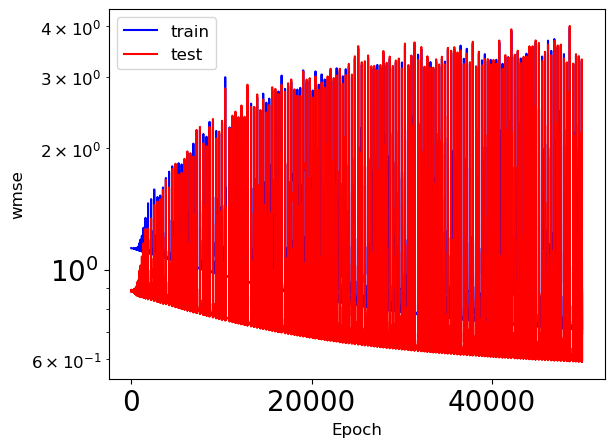

2/2 [==============================] - 0s 3ms/step


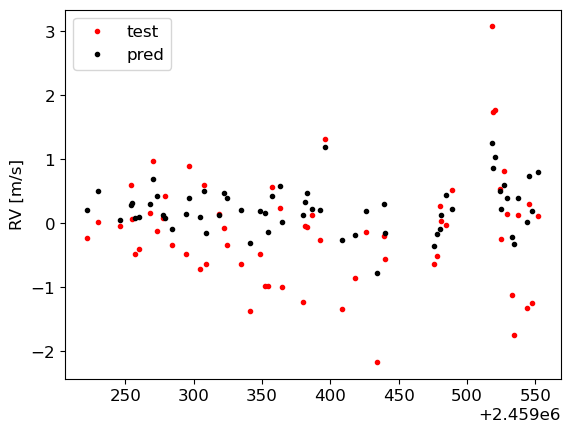

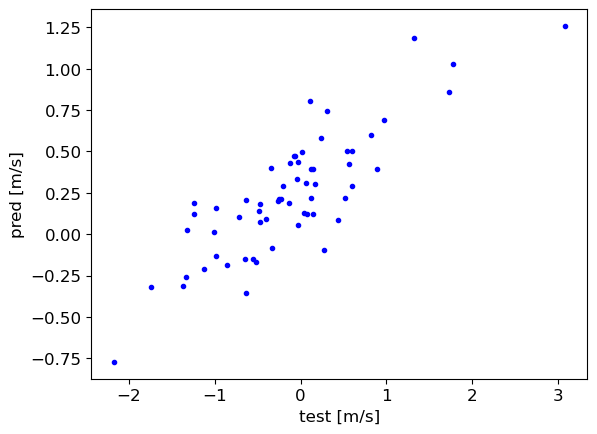

(0.3463417990114821, 0.6330321390430029)


In [30]:
X = CCF_daily.T
Y = rv_daily - np.mean(rv_daily)
print(X.shape, Y.shape)
###################
# build the model #
###################
input_dim = X.shape[1]
lr_model = Sequential()
# lr_model.add(Dense(32, activation=tf.nn.relu, kernel_initializer='uniform', 
#                 input_dim = input_dim)) 
# lr_model.add(Dense(16, kernel_initializer='uniform', activation=tf.nn.relu))
lr_model.add(Dense(16, activation=tf.keras.activations.linear, kernel_initializer='uniform', 
                input_dim = input_dim)) # add bias term!
# lr_model.add(Dense(20, kernel_initializer='uniform', activation=tf.nn.relu))
# lr_model.add(Dense(20, kernel_initializer='uniform', activation=tf.nn.tanh))
lr_model.add(Dense(1, kernel_initializer='uniform', activation=tf.keras.activations.linear))

y_test, y_pred = model_MLP(X, Y, lr_model,  epochs=50000, learning_rate=5e-3)